<a href="https://colab.research.google.com/github/paascorb/AgendaAndroidStudio/blob/master/TrabajoAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Profundo - Trabajo 12
*Pablo Ascorbe Fernández e Ignacio Marco Pérez.*

Ignacio busca todos los "TODO" que son los que están abiertos a mejora.

## Introducción

Como trabajo final de la asignatura decidimos trabajar con algo que no habíamos visto hasta el momento durante la misma: el procesamiento de audio. Hay modelos que se dedican a <a href="https://huggingface.co/docs/transformers/tasks/asr">reconocer el habla</a> o a <a href=https://huggingface.co/docs/transformers/tasks/audio_classification>clasificar pistas de audio</a>.<br><br> 

En nuestro caso, queríamos ir un poquito más allá y, a partir de la clasificación de audio, buscar un modelo que nos indique como de parecidas son dos pistas. Además, se nos ocurrió que esto podría ser muy interesante en el mundo de la música y, sobre todo, en el de las piezas clásicas.<br><br>

Indagando un poco, vimos que existían un tipo de redes llamadas "redes siamesas" especializadas en medir similitudes. El punto de partida fue el artículo [[1]](#bib1), donde se explica el funcionamiento y la relevancia de la aplicación de las redes siamesas a este campo. No queremos clasificar música por géneros (rock, pop... o, en nuestro caso: renancentista, barroca...) sino que queremos encontrar piezas que se parezcan o difieran en su propia esencia.

## Objetivos

Los objetivos de este trabajo derivan en: la comprensión y utilización de las redes siamesas, junto con una explicación de su funcionamiento teórico; la adquisición de un banco de datos de obras clásicas y su procesamiento necesario para que los modelos las puedan ingerir; entrenamiento y validación de varios modelos; unas conclusiones resultado del trabajo y de los frutos de los modelos entrenados.

## Recursos y técnicas

En esta sección se detallará qué datos usaremos y una referencia para conseguirlos. Además, una detallada explicación de como funcionan las redes siamesas y el porqué de la transformación de las pistas de audio a espectrogramas.

### Datos

Los datos son uno de los puntos más importantes en todo proceso de aprendizaje automático; sin ellos, los modelos serían una cáscara vacía de capas y capas de neuronas vacuas. Como un árbol seco que necesita desesperadamente una grácil lluvia de primavera, cada gota que rejuvenece a nuestro seco árbol compone, en nuestro caso, una obra de Bach o de Chopin. Y ¿dónde encontrar esas nubes borrascosas?, aquí: https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi.

Además, ya que los formatos .mid solo se quedan con las notas, no con los sentimientos o las sensaciones de una buena interpretación...*Ignacio borra esto o rellenalo si haces esta parte*. *TODO*

Como podemos comprobar, nuestos datos son pistas de audio, y nuestros modelos esperan matrices de números. No obstante, en [[1]](#bib1) se explica que una solución a este problema es representar cada pista en un espectrograma, más concretamente en uno de mel [[2]](#bib2), que es un espectrograma donde las frecuencias son convertidas a la escala de mel (escala logarítmica), más próxima a cómo los humanos percibimos el sonido.

Por poner un ejemplo, vamos a visualizar el espectograma y el espectrograma de mel para Requiem de Mozart.

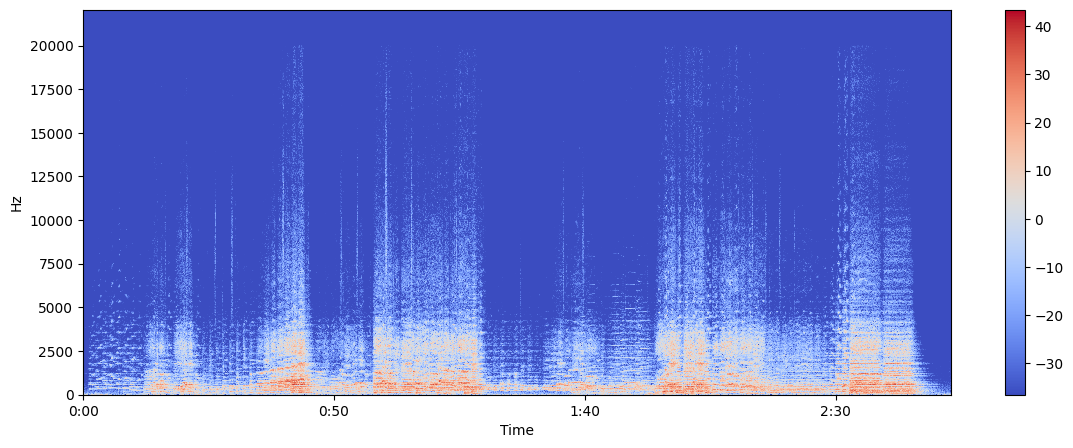

In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display


# Generamos el espectrograma
x, sr = librosa.load("lacrimosa.wav", sr=44100)

# Lo mostamos
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

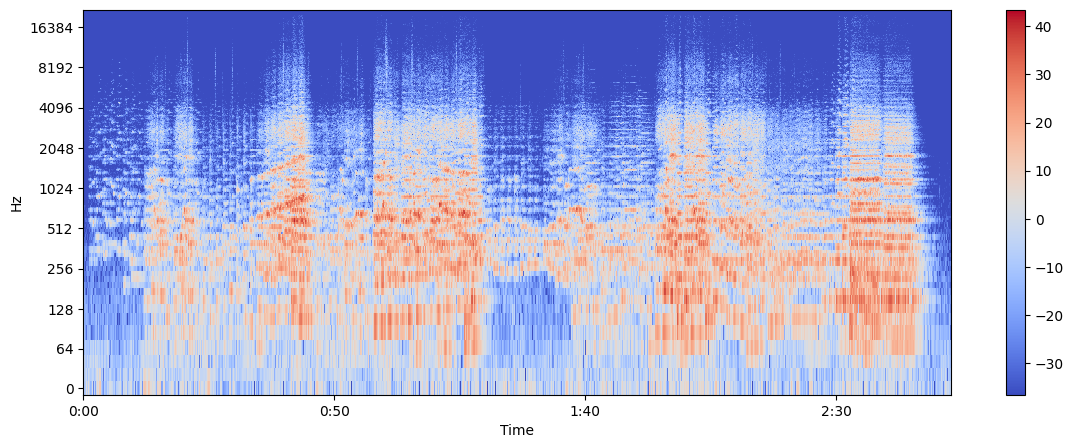

In [2]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log') # Indicamos la escala logarítimica para el espectrograma de mel
plt.colorbar()

### Técnicas

En esta sección se busca dar una explicación a qué son y cómo funcionan las redes siamesas.

Las redes siamesas se componen, como sugiere su nombre, de dos redes absolutamente idénticas; no solo en estructura sino que también comparten los parámetros y pesos. Dada una pareja de entrada (dos obras clásicas), se proporcionará un miembro de la pareja a una de las redes y el otro a la otra, de esta forma cada, red generará un vector de características que representará a la imagen que le ha "tocado". Por último, calculando la distancia entre estos vectores podremos determinar cuán distantes o próximas son las entradas recibidas.

Para entrenar estas redes cada imagen tendrá una distancia de 0 con las imágenes de su misma clase y de 1 con las de otras. Tras cada iteración se comprobará la similaridad con funciones de pérdida como: Contrastive loss, triplet loss, and circle loss [[3]](#bib3).

Para ilustrar un poco este esquema contamos con la siguiente figura.

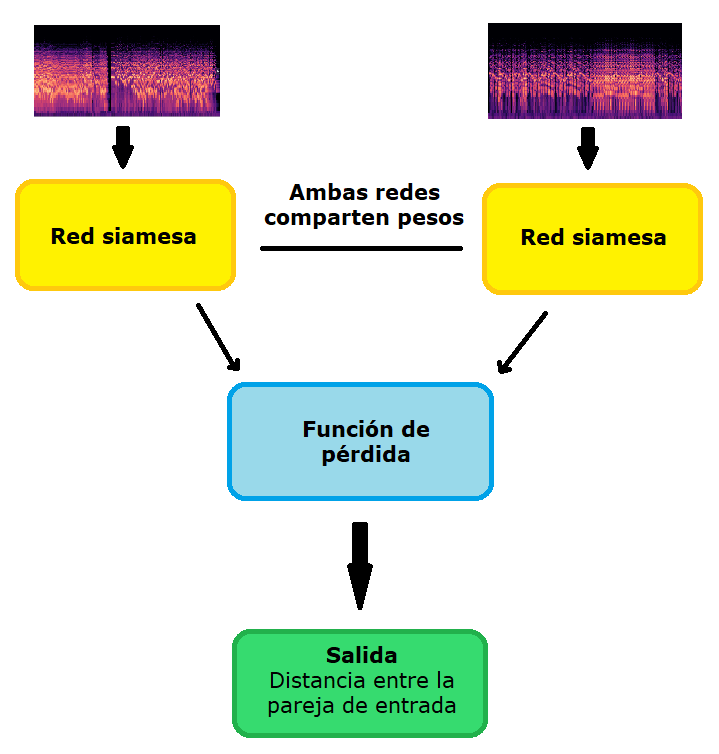

Las ventajas de este tipo de técnicas son: que pueden trabajar con datos no balanceados (nuestros datos así lo estarán, ya que no tendremos tantos datos de Borodin como de Beethoven) y que además no requieren de demasiados datos para funcionar. Las desventajas son que estos modelos generalizan mal, es decir, que si nuestra red ha sido entrenada para diferencias entre piezas clásicas funcionará mal para diferenciar caras (como pasa con muchas otras técnicas), además, de que son sensibles a pequeñas variaciones en las entradas.

Para el entrenamiento de estas redes, se van cogiendo lotes de muestras aleatoriamente y se van comparando con lo que realmente distan y lo que se ha predicho. También, existe otra forma que es dada una imagen base, ir comparando las que se parecen y las que difieren. Todo esto podemos encontrarlo más detallado en una webinar en castellano en: https://www.youtube.com/watch?v=jizv7MWXTVQ&ab_channel=ReconoSERID.

## Desarrollo

Este apartado, el grueso del trabajo, consiste en recoger los datos, hacer las transformaciones necesarias y alimentar un modelo capaz de inferir sobre unas imágenes de test.

### Librerías

Cargamos las librerías necesarias.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
import random
from PIL import Image
import PIL.ImageOps   
import os
import sys 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from midi2audio import FluidSynth
import librosa
import librosa.display
import gc

### Carga del dataset

En esta primera aproximación cargaremos los datos de: https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi. Recordemos que están en formato .mdi y necesitamos transformarlos a .wav, para posteriormente, transformarlos a un espectrograma de mel. Teniendo las imágenes de nuestros audios podremos entrenar las redes.

In [ ]:
!mkdir audio
!wget https://www.dropbox.com/s/k95yd2qri5xlsqr/piezas_clasicas.zip?dl=0 -O dataset.zip
!unzip -qq dataset.zip -d audio

--2023-04-27 21:01:11--  https://www.dropbox.com/s/k95yd2qri5xlsqr/piezas_clasicas.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k95yd2qri5xlsqr/piezas_clasicas.zip [following]
--2023-04-27 21:01:12--  https://www.dropbox.com/s/raw/k95yd2qri5xlsqr/piezas_clasicas.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce9816fbb3666167dc8a26990cc.dl.dropboxusercontent.com/cd/0/inline/B69fmmxZkWJmNCllHQ8nkN3ZSuUTsf4wYpOHpytc_32PyUj5AUVsSE0DYiOLeBjyWjV4l1lK9WfuOk95c-5FQaD7nERG2W7eq0wlZwkp-brood3k02Z3i9GTWptFZI91mnWMpG3glyFoazkcZOCjc8Ag-3TyTiQKAvaByBO29_q3ow/file# [following]
--2023-04-27 21:01:12--  https://uce9816fbb3666167dc8a26990cc.dl.dropboxusercontent.com/cd/0/inline/B69fmmxZkWJmNCllHQ8nkN3ZSuUTsf4wYpOHpytc_32PyUj5AUVsSE

### Procesamiento de los datos

La librería midi2audio nos permite hacer estas transformaciones de .mid a .wav.

In [ ]:
!pip install midi2audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

Ahora vamos a ir recorriendo el directorio con los archivos .mid para transformarlos a .wav y, posteriormente, crear el espectrograma en escala logarítmica que guardaremos como imagen.

In [ ]:
# Creamos los directorios donde estarán nuestros datos
os.mkdir("audio_wav")
os.mkdir("dataset")

# Calculamos la lista de subcarpetas de nuestros datos, es decir, nuestras
# etiquetas (compositores).
compositores = [x[0].split('/')[1] for x in os.walk("audio") if x[0] != 'audio']
m = len(compositores)

# Para cada compositor transformamos los archivos .mid a .wav; con el fichero
# .wav generamos y guardamos el espectrograma.
for i, compositor in enumerate(compositores):

  os.mkdir("audio_wav/"+compositor)
  os.mkdir("dataset/"+compositor)
  archivos = os.listdir("audio/"+compositor)
  n = len(archivos)

  for j, f in enumerate(archivos):

      # Transformamos el fichero .mid a .wav.
      FluidSynth().midi_to_audio("audio/"+compositor+"/"+f, 
                                 "audio_wav/"+compositor+"/"+f.split('.')[0]+'.wav')

      # Generamos el espectrograma
      x, sr = librosa.load("audio_wav/"+compositor+"/"+f.split('.')[0]+'.wav', sr=44100)

      X = librosa.stft(x)
      Xdb = librosa.amplitude_to_db(abs(X))

      # Lo guardamos
      fig = plt.Figure()
      canvas = FigureCanvas(fig)
      ax = fig.add_subplot(111)
      p = librosa.display.specshow(Xdb, sr=sr, ax=ax, x_axis='time', y_axis='log')
      fig.savefig("dataset/"+compositor+"/"+f.split('.')[0]+'.jpg')

      # Vamos mostrando el progreso
      sys.stdout.write(f'\rFase: {i+1}/{m} - Progreso: {j+1}/{n}')
      sys.stdout.flush()

      #Eliminamos las variables porque sino la memoria se desborda
      del x, sr, X, Xdb, fig, canvas, ax, p
      gc.collect()

Fase: 19/19 - Progreso: 3/3

Ha terminado, esto es un milagro. Tras hora y pico, tenemos el dataset.

Vamos a comprimir la carpeta y descargarla, para subirla a dropbox y no tener que volver a generar los espectrogramas.

In [ ]:
!zip -r dataset.zip dataset -qq

### Construcción de las redes siamesas "a mano"

Referencia: https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/

Cargamos los datos que previamente hemos generado.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/j2f5sir1vqsbise/dataset_piezas_clasicas.zip?dl=0 -O dataset.zip
!unzip -qq dataset.zip

In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="dataset_piezas_clasicas/train/")

Definimos una clase que genere el dataset para las redes siamesas, recordemos que irá cogiendo muestras de manera aleatoria.

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        #print("Imagen 1: ",img0_tuple[1],"Imagen 2: ",img1_tuple[1],'\n')
        classes = (img0_tuple[1], img1_tuple[1])

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32)), classes
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Transformamos nuestras imágenes a tensores.

In [ ]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

Y creamos un dataloader con las muestras de entrenamiento, para tener una noción de como funciona, vemos que imágenes de la misma clase tienen 0 y de distinta 1. Es un poco complicado determinar si esto es así, con las caras es más fácil, pero nos creemos que lo es.

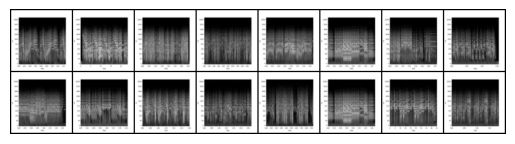

[1. 1. 1. 0. 1. 0. 1. 0.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
img = torchvision.utils.make_grid(concatenated)

npimg = img.numpy()

plt.axis("off")
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

print(example_batch[2].numpy().reshape(-1))

Generamos la red siamesa en sí. Vemos que tampoco dispone de demasiadas capas.

In [ ]:

#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

Y definimos la función de pérdida, en este caso ContrastiveLoss.

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

Generamos el dataset con el que entrenará la red.

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

Creamos la red.

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Y entrenamos 100 épocas.

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label, classes) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch} Current loss {loss_contrastive.item()}", end="\r")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

plt.plot(counter,loss_history)
plt.show()

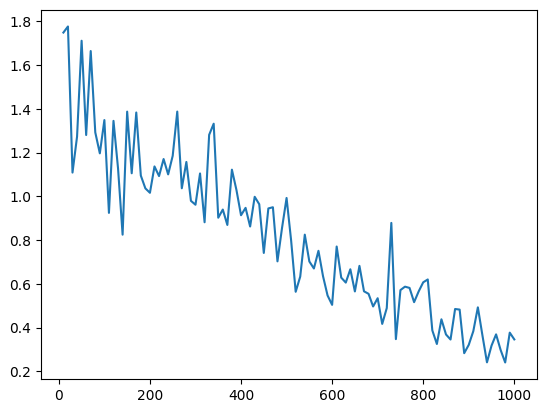

Una función para mostrar imagenes y comprobar qué tal infiere la red.

In [ ]:
def imshow(img1, img2, text=None):

    concatenated = torch.cat((img1, img2), 0)
    img = torchvision.utils.make_grid(concatenated)

    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 

Y comprobamos con el dataset de test cómo de bien funciona.

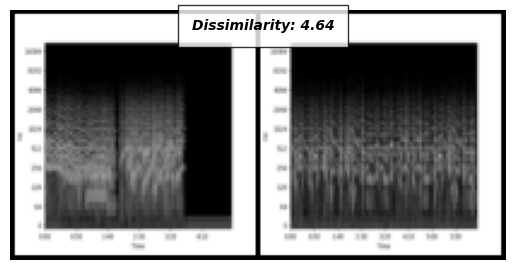

Imagen 1:  tensor([0]) Imagen 2:  tensor([5]) 



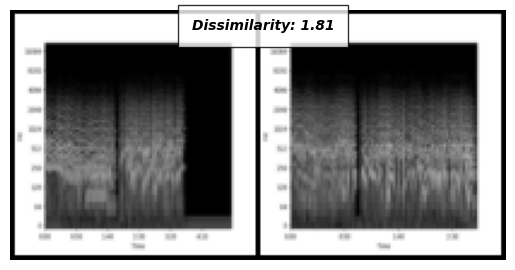

Imagen 1:  tensor([0]) Imagen 2:  tensor([0]) 



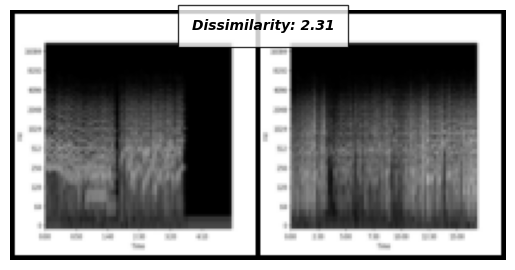

Imagen 1:  tensor([0]) Imagen 2:  tensor([4]) 



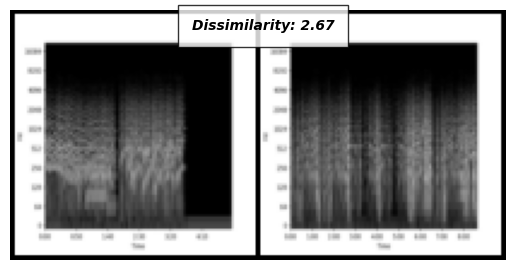

Imagen 1:  tensor([0]) Imagen 2:  tensor([2]) 



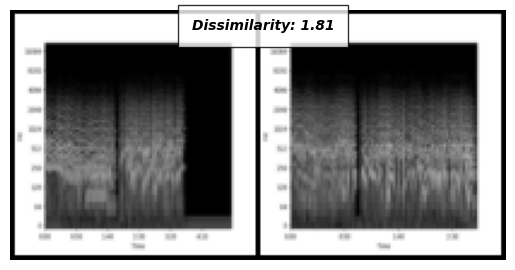

Imagen 1:  tensor([0]) Imagen 2:  tensor([0]) 



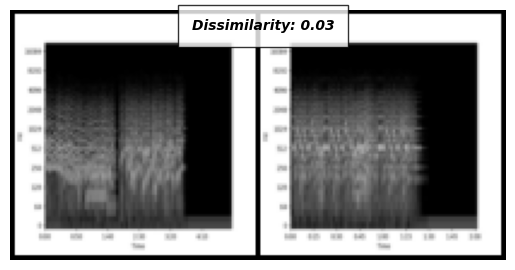

Imagen 1:  tensor([0]) Imagen 2:  tensor([2]) 



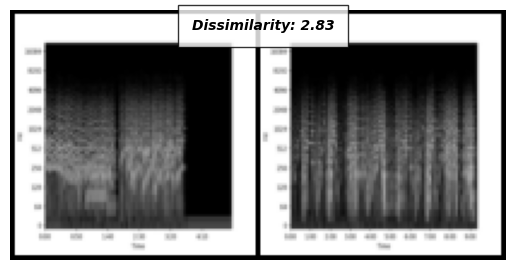

Imagen 1:  tensor([0]) Imagen 2:  tensor([1]) 



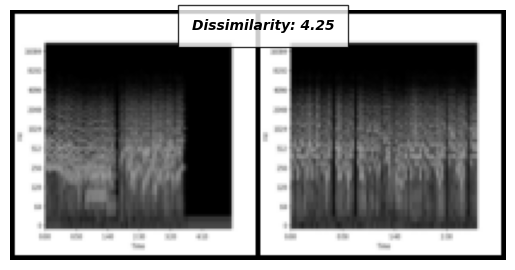

Imagen 1:  tensor([0]) Imagen 2:  tensor([3]) 



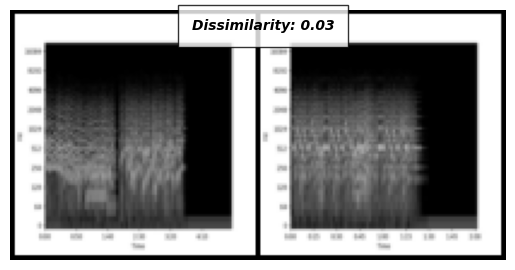

Imagen 1:  tensor([0]) Imagen 2:  tensor([2]) 



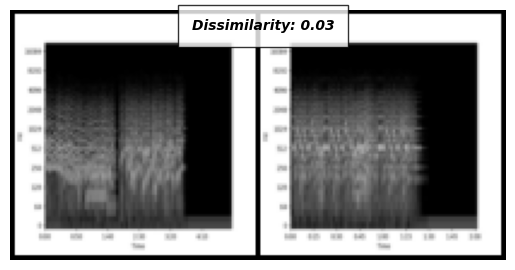

Imagen 1:  tensor([0]) Imagen 2:  tensor([2]) 



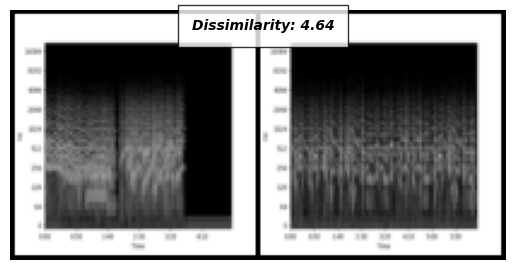

Imagen 1:  tensor([0]) Imagen 2:  tensor([5]) 



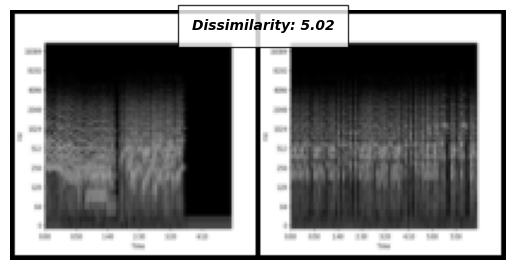

Imagen 1:  tensor([0]) Imagen 2:  tensor([3]) 



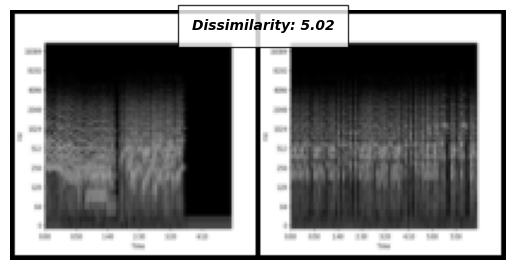

Imagen 1:  tensor([0]) Imagen 2:  tensor([3]) 



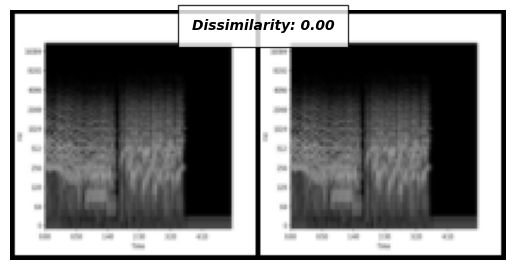

Imagen 1:  tensor([0]) Imagen 2:  tensor([0]) 



In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="dataset_piezas_clasicas/test/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _, classes1 = next(dataiter)

for i in range(14):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2, classes2  = next(dataiter)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(x0, x1, f'Dissimilarity: {euclidean_distance.item():.2f}')
    print("Imagen 1: ",classes1[0],"Imagen 2: ",classes2[1],'\n')

Vemos que en general, las que son de la misma clase tienen distancias cercanas, mientras que las que son de distinta no. Aquí hemos tenido el problema de que alguna de las imágenes de test se han genrado mal y al compararlas entre ellas figuran como muy parecidas (tiene sentido), pero sí podemos ver que realmente está infiriendo bien.

In [ ]:
!unzip -qq prueba.zip

Vamos a realizar una pruebecilla, le vamos a pasar imágenes de Bach que no ha visto previamente, y las vamos a comparar con otras de Chopin y de Beethoven.

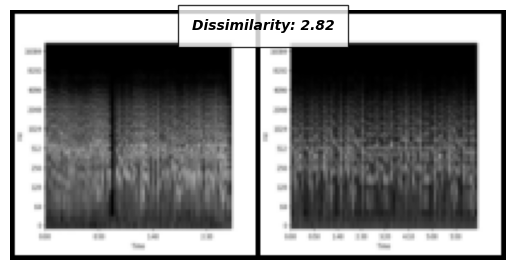

Imagen 1:  tensor([0]) Imagen 2:  tensor([1]) 



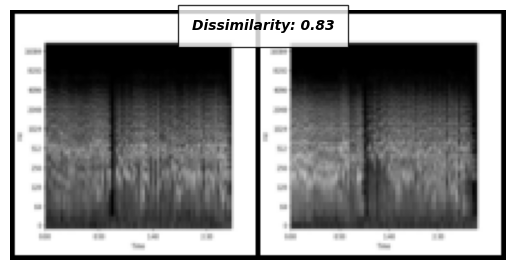

Imagen 1:  tensor([0]) Imagen 2:  tensor([0]) 



In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="prueba/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _, classes1 = next(dataiter)

for i in range(2):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2, classes2  = next(dataiter)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(x0, x1, f'Dissimilarity: {euclidean_distance.item():.2f}')
    print("Imagen 1: ",classes1[0],"Imagen 2: ",classes2[1],'\n')

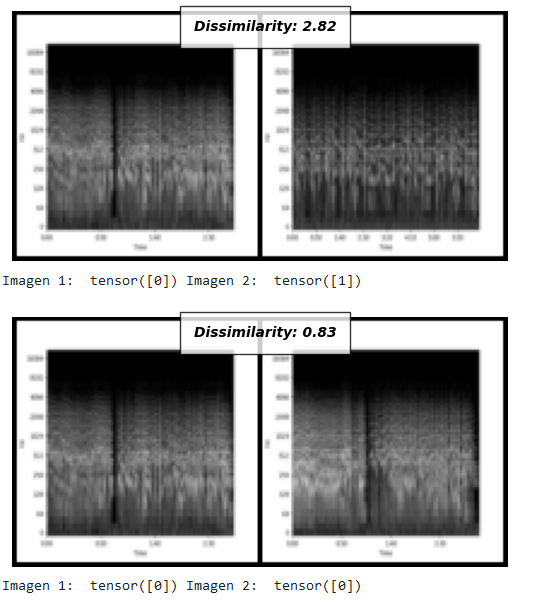

Guardo una imágen por si acaso. Vemos que efectivamente, dos piezas de Bach están próximas, pero una de Bach con otra de Beethoven no tanto. Luego es capaz de inferir sobre "clases" que no ha visto anteriormente y lo hace bastante bien.

Vistos estos resultados, vamos a repetir el procedimiento pero mejorando la calidad de los espectrogramas, para comprobar si afecta o no al modelo, pero sobre todo para poder nosotros comprobarlo mejor. No hay mucho que comentar en todo el procedimiento ya que es bastante parecido al anterior.

In [ ]:
!mkdir audio
!wget https://www.dropbox.com/s/k95yd2qri5xlsqr/piezas_clasicas.zip?dl=0 -O dataset.zip
!unzip -qq dataset.zip -d audio

In [ ]:
!pip install midi2audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

Hacemos unas pruebas para comprobar la imagen deseada.

In [ ]:
from midi2audio import FluidSynth
import os
import sys
from midi2audio import FluidSynth
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

#for loading and visualizing audio files
import librosa
import librosa.display

FluidSynth().midi_to_audio("audio/albeniz/alb_esp3.mid", 
                           "alb_esp3.wav")
x, sr = librosa.load("alb_esp3.wav", sr=44100)

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

In [ ]:
# Una prueba para comprobar cómo conseguir solo el espectrograma

fig = plt.Figure(figsize=(100, 50))
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
librosa.display.specshow(Xdb, sr=sr, ax=ax, x_axis='time', y_axis='log')
plt.axis('off')
plt.axis("tight")
plt.axis("image")
fig.savefig("prueba.png", bbox_inches='tight', pad_inches = 0)

Y teniendo esto ahora generamos los espectrogramas sin los ejes, en formato .png y con mejor calidad.

In [ ]:
import os
import sys
from midi2audio import FluidSynth
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

#for loading and visualizing audio files
import librosa
import librosa.display

import gc

# Creamos los directorios donde estarán nuestros datos
os.mkdir("audio_wav")
os.mkdir("dataset")

# Calculamos la lista de subcarpetas de nuestros datos, es decir, nuestras
# etiquetas (compositores).
compositores = [x[0].split('/')[1] for x in os.walk("audio") if x[0] != 'audio']
m = len(compositores)

# Para cada compositor transformamos los archivos .mid a .wav; con el fichero
# .wav generamos y guardamos el espectrograma.
for i, compositor in enumerate(compositores):

  os.mkdir("audio_wav/"+compositor)
  os.mkdir("dataset/"+compositor)
  archivos = os.listdir("audio/"+compositor)
  n = len(archivos)

  for j, f in enumerate(archivos):

      # Transformamos el fichero .mid a .wav.
      FluidSynth().midi_to_audio("audio/"+compositor+"/"+f, 
                                 "audio_wav/"+compositor+"/"+f.split('.')[0]+'.wav')

      # Generamos el espectrograma
      x, sr = librosa.load("audio_wav/"+compositor+"/"+f.split('.')[0]+'.wav', sr=44100)

      X = librosa.stft(x)
      Xdb = librosa.amplitude_to_db(abs(X))

      # Lo guardamos
      fig = plt.Figure(figsize=(100, 50))
      canvas = FigureCanvas(fig)
      ax = fig.add_subplot(111)
      librosa.display.specshow(Xdb, sr=sr, ax=ax, x_axis='time', y_axis='log')
      plt.axis('off')
      plt.axis("tight")
      plt.axis("image")
      fig.savefig("dataset/"+compositor+"/"+f.split('.')[0]+'.png', bbox_inches='tight', pad_inches = 0)

      # Vamos mostrando el progreso
      sys.stdout.write(f'\rFase: {i+1}/{m} - Progreso: {j+1}/{n}')
      sys.stdout.flush()

      #Eliminamos las variables porque sino la memoria se desborda
      del x, sr, X, Xdb, fig, canvas, ax
      gc.collect()

In [ ]:
!zip -r dataset.zip dataset -qq

Tenemos los datos, vamos cargarlos y entrenar el modelo.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/e94vf4t9067jfv4/dataset_trabajoAP.zip?dl=0 -O dataset.zip
!unzip -qq dataset.zip

In [ ]:
folder_dataset = datasets.ImageFolder(root="dataset/train/")

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        #print("Imagen 1: ",img0_tuple[1],"Imagen 2: ",img1_tuple[1],'\n')
        classes = (img0_tuple[1], img1_tuple[1])

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32)), classes
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

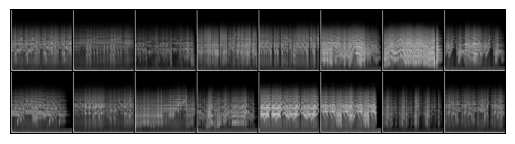

[1. 1. 0. 0. 1. 0. 1. 1.]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
img = torchvision.utils.make_grid(concatenated)

npimg = img.numpy()

plt.axis("off")
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

print(example_batch[2].numpy().reshape(-1))

Vemos que ahora las imágenes se ven mucho mejor.

In [ ]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Ponemos menos épocas porque con los nuevos datos le cuesta mucho más entrenar.

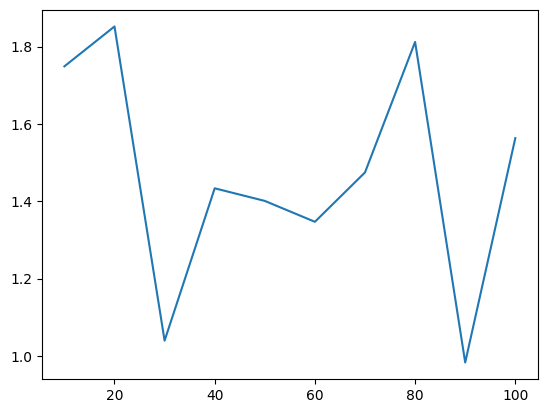

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(10):

    # Iterate over batches
    for i, (img0, img1, label, classes) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch} Current loss {loss_contrastive.item()}", end="\r")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

plt.plot(counter,loss_history)
plt.show()

In [ ]:
def imshow(img1, img2, text=None):

    concatenated = torch.cat((img1, img2), 0)
    img = torchvision.utils.make_grid(concatenated)

    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Generamos un par de métodos para forzar al dataloader a darnos las imágenes que queremos. Ya que las recibimos de manera aleatoria, necesitamos que inicialmente nos de una imagen de Bach, y posteriormente las compare con el resto.

In [ ]:
def get_elem(clas, dataloader):
  dataiter = iter(test_dataloader)
  x0, _, _, classes1 = next(dataiter)
  while classes1[0] != clas:
    try:
      x0, _, _, classes1 = next(dataiter)
    except:
      dataiter = iter(test_dataloader)
      x0, _, _, classes1 = next(dataiter)
  return x0, classes1

In [ ]:
def get_elem_diferent(clas, elem, dataloader):
  dataiter = iter(test_dataloader)
  x1, _, _, classes2 = next(dataiter)
  while torch.all(x0.eq(x1)).item() or classes2[0]!=clas:
    try:
      x1, _, _, classes2 = next(dataiter)
    except:
      dataiter = iter(test_dataloader)
      x1, _, _, classes2 = next(dataiter)
  return x1, classes2

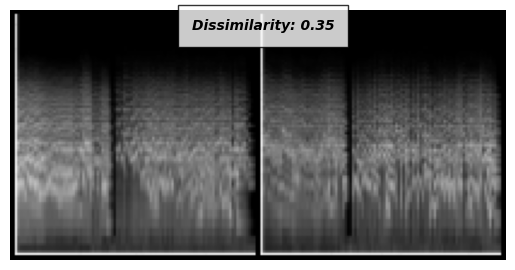

Imagen 1:  0 Imagen 2:  0 



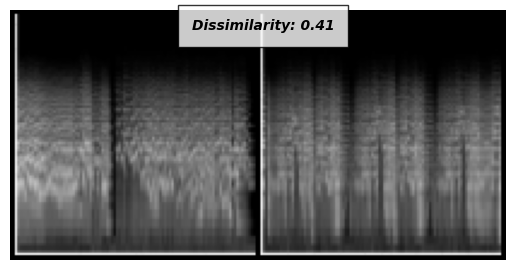

Imagen 1:  0 Imagen 2:  1 



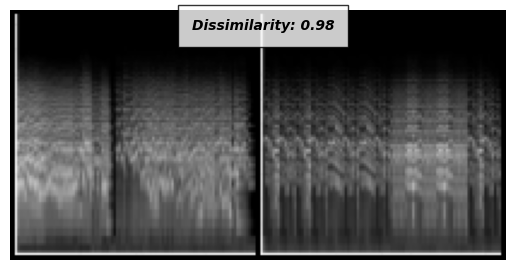

Imagen 1:  0 Imagen 2:  2 



In [ ]:
folder_dataset_test = datasets.ImageFolder(root="dataset/test/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Cogemos un elemento de la clase 0 ("Bach") que no ha visto previamente el modelo
x0, classes1 = get_elem(0, test_dataloader)

for i in range(3):
    # Iterate over 10 images and test them with the first image (x0)
    x1, classes2  = get_elem_diferent(i, x0, test_dataloader)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(x0, x1, f'Dissimilarity: {euclidean_distance.item():.2f}')
    print("Imagen 1: ",classes1[0].item(),"Imagen 2: ",classes2[0].item(),'\n')

Tenemos los resultados deseados; no obstante, vemos que como el modelo no ha entrenado demasiado, la distancia entre una pieza de Bach (compositor que no ha visto en entrenamiento el modelo) con otra de Beethoven es similar a la distancia con la otra pieza del mismo compositor. Pero aún así, vemos que las piezas del mismo compositor las situa cerca, mientras que las del resto las distancia algo más.<br><br>Solo por hacerlo un poco más visual, vamos a poner en la etiqueta el nombre del compositor.

In [ ]:
import os

[x[0].split('/')[2] for x in os.walk("dataset/test") if x[0] != 'dataset/test']

['beeth', 'bach', 'chopin']

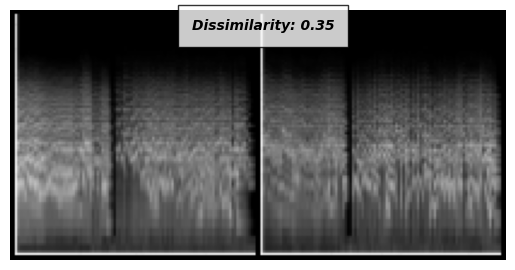

Imagen 1:  bach Imagen 2:  bach 



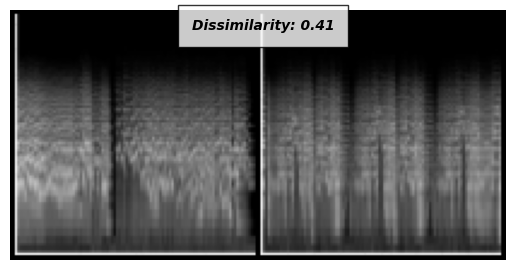

Imagen 1:  bach Imagen 2:  beeth 



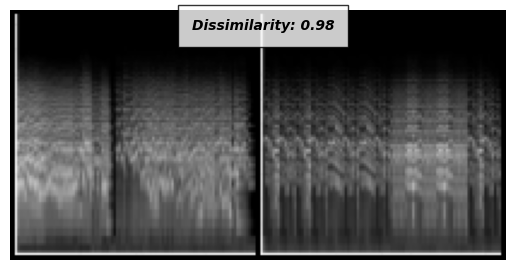

Imagen 1:  bach Imagen 2:  chopin 



In [ ]:
folder_dataset_test = datasets.ImageFolder(root="dataset/test/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

compositores = [x[0].split('/')[2] for x in os.walk("dataset/test") if x[0] != 'dataset/test']
compositores.sort()

# Cogemos un elemento de la clase 0 ("Bach") que no ha visto previamente el modelo
x0, classes1 = get_elem(0, test_dataloader)

for i in range(3):
    # Iterate over 10 images and test them with the first image (x0)
    x1, classes2  = get_elem_diferent(i, x0, test_dataloader)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(x0, x1, f'Dissimilarity: {euclidean_distance.item():.2f}')
    print("Imagen 1: ",compositores[classes1[0].item()],
          "Imagen 2: ",compositores[classes2[0].item()],'\n')

Perfecto, pues tenemos nuestros resultados. Vemos como un compositor se diferencia del resto y se parece a sí mismo en sus piezas, pero como hay compositores que son más parecidos a otros.

### Utilizando un modelo preentrenado para la construcción de la red

https://keras.io/examples/vision/siamese_network/

*TODO*

## Bibliografía

<a name="bib1"></a>
[1] $\;\;\;\;\;\;$T. Vassallo. "Calculating Audio Song Similarity Using Siamese Neural Networks". Medium. https://towardsdatascience.com/calculating-audio-song-similarity-using-siamese-neural-networks-62730e8f3e3d.

<a name="bib2"></a>
[2]$\;\;\;\;\;\;$L. Roberts. "Understanding the Mel Spectrogram". Medium. https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53.

 <a name="bib3"></a>
 [3]$\;\;\;\;\;\;$ A. Dutt. "Siamese Networks Introduction and Implementation". Medium. https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee.